<a href="https://colab.research.google.com/github/KatBotkowska/Pandas-Numpy-exercices/blob/master/gsm_umts_lte_cdma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dane ściągnięte z https://dane.gov.pl/pl/dataset/1075,wykazy-pozwolen-radiowych-dla-stacji-bazowych-telefonii-komorkowej-gsm-umts-lte-oraz-stacji-wykorzystujacych-technologie-cdma

###Import

In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 293 kB/s 
     |████████████████████████████████| 6.3 MB 37.9 MB/s 


In [3]:
import pandas as pd
import glob
import os
import re
import math
from itertools import combinations
from geopy.distance import distance
import geopandas as gpd
import matplotlib.pyplot as plt

###Mount gdrive and files 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#already done
#!unzip '/content/gdrive/MyDrive/CodersCrew/wykazy_pozwolen_gsm_umts_lte_cdma.zip' -d '/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma'

Archive:  /content/gdrive/MyDrive/CodersCrew/wykazy_pozwolen_gsm_umts_lte_cdma.zip
replace /content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/UMTS2100 - stan na 2022-02-25.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
files = glob.glob(f"/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/*.xlsx")

In [ ]:
# files = glob.glob(f"/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/*.xlsx")
# def create_df(files):
#     for file in files:
#         title = os.path.splitext(os.path.basename(file))[0].split()[0]
#         # print(title)
#         title == pd.read_excel(file)
#     return title
#         # print(os.path.splitext(os.path.basename(file)), os.path.dirname(file))


###Create data dictionary from excell files

In [6]:
def create_dict_with_df(files):
    dfs={}
    for file in files:
        title = os.path.splitext(os.path.basename(file))[0].split('_')[0].upper()
        dfs[title] = pd.read_excel(file)
    return dfs

In [7]:
dfs = create_dict_with_df(files)
dfs.keys()

dict_keys(['CDMA420', 'CDMA450', '5G1800', '5G2100', 'GSM1800', '5G2600', 'GSM900', 'LTE2600', 'LTE2100', 'LTE1800', 'LTE420', 'LTE450', 'LTE800', 'LTE900', 'UMTS1800', 'UMTS2100', 'UMTS900'])

In [8]:
dfs['CDMA450'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nazwa Operatora    0 non-null      object
 1   Nr Decyzji         0 non-null      object
 2   Rodzaj decyzji     0 non-null      object
 3   Data ważności      0 non-null      object
 4   Dł geogr stacji    0 non-null      object
 5   Szer geogr stacji  0 non-null      object
 6   Miejscowość        0 non-null      object
 7   Lokalizacja        0 non-null      object
 8   IdStacji           0 non-null      object
 9   TERYT              0 non-null      object
dtypes: object(10)
memory usage: 0.0+ bytes


In [9]:
#check if all collumns are the same in each df
all([len(dfs['LTE420'].columns.intersection(df.columns)) == dfs['LTE420'].shape[1] for df in dfs.values()])

True

In [10]:
#add columns for RAT and Częstotliwość to join df
for elem in dfs.keys():
    dfs[elem].insert(0, 'RAT', ''.join([e for e in elem if not e.isdigit()] if elem[0] != '5' else "5G"))
    dfs[elem].insert(1, 'Częstotliwość', ''.join([e for e in elem[2:] if e.isdigit()]))
    

##LTE

###Create LTE data frame

In [11]:
#concatenate all LTE's df to one
LTE_keys = [key for key in dfs.keys() if key.startswith('L')]
LTE = pd.concat([dfs[key] for key in LTE_keys])


In [12]:
LTE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96339 entries, 0 to 880
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RAT                96339 non-null  object        
 1   Częstotliwość      96339 non-null  object        
 2   Nazwa Operatora    96339 non-null  object        
 3   Nr Decyzji         96339 non-null  object        
 4   Rodzaj decyzji     96339 non-null  object        
 5   Data ważności      96339 non-null  datetime64[ns]
 6   Dł geogr stacji    96339 non-null  object        
 7   Szer geogr stacji  96339 non-null  object        
 8   Miejscowość        96339 non-null  object        
 9   Lokalizacja        96175 non-null  object        
 10  IdStacji           96339 non-null  object        
 11  TERYT              96339 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 9.6+ MB


In [13]:
LTE.shape

(96339, 12)

In [14]:
LTE.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
count,96339,96339,96339,96339,96339,96339,96339,96339,96339,96175,96339,9.633900e+04
unique,1,7,6,31310,2,137,16102,12668,7223,27345,29728,NaN
top,LTE,1800,P4 Sp. z o.o.,MNET/15/48847/13/21,zmP,2023-08-31 00:00:00,"21E01'42""","52N13'59""",Warszawa,1,ZLT3003,NaN
freq,96339,30094,37519,5,75890,7399,49,107,7426,68,12,NaN
first,NaN,NaN,NaN,NaN,NaN,2022-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2032-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.736602e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.181927e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.010110e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.061011e+06


In [16]:
LTE.head()

,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
0,LTE,2600,AERO 2 Sp. z o.o.,LTE2600/5/0006/2/17,zmP,2023-03-31,"20E00'48""","51N31'48""",Tomaszów Mazowiecki,Prezydenta Ignacego Mościckiego 14\18,BT30063,1016011
1,LTE,2600,AERO 2 Sp. z o.o.,LTE2600/5/0007/2/17,zmP,2023-03-31,"19E56'09""","52N05'36""",Łowicz,Powstańców 1863 r. 12,BT30880,1005011
2,LTE,2600,AERO 2 Sp. z o.o.,LTE2600/5/0008/2/17,zmP,2023-03-31,"18E43'33""","51N35'31""",Sieradz,Jana Pawła II 28,BT31183,1014011
3,LTE,2600,AERO 2 Sp. z o.o.,LTE2600/5/0009/2/17,zmP,2023-03-31,"17E59'32""","51N16'29""",Kępno,dz. nr 2044\20,BT32993,3008033
4,LTE,2600,AERO 2 Sp. z o.o.,LTE2600/5/0010/2/17,zmP,2023-03-31,"17E29'52""","51N57'48""",Jarocin,Węglowa 1,BT33131,3006023


In [17]:
#czy są puste komórki
LTE.isnull().sum()

RAT                    0
Częstotliwość          0
Nazwa Operatora        0
Nr Decyzji             0
Rodzaj decyzji         0
Data ważności          0
Dł geogr stacji        0
Szer geogr stacji      0
Miejscowość            0
Lokalizacja          164
IdStacji               0
TERYT                  0
dtype: int64

In [18]:
LTE['Lokalizacja']

0      Prezydenta Ignacego Mościckiego 14\18
1                      Powstańców 1863 r. 12
2                           Jana Pawła II 28
3                             dz. nr 2044\20
4                                  Węglowa 1
                       ...                  
876                                      295
877                                      110
878                                       6D
879                                   4455/2
880                                  2, 7/22
Name: Lokalizacja, Length: 96339, dtype: object

###zmiana gps na koordynaty geograficzne

In [ ]:
dlugosc = LTE['Dł geogr stacji'][0].iloc[0]
dlugosc
szerokosc = LTE['Szer geogr stacji'][0].iloc[0]
szerokosc
# [i for i in dlugosc if i.isdigit()]

'50N43\'39"'

In [ ]:
LTE['Dł geogr stacji']= [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in LTE['Dł geogr stacji']]]


In [ ]:
LTE['Dł geogr stacji'] = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in LTE['Dł geogr stacji'] ]

In [ ]:
LTE['Dł geogr stacji']

0        20.538889
1        20.349444
2        22.133889
3        23.125556
4        23.761944
           ...    
22628    18.845556
22629    23.177500
22630    22.993056
22631    22.977778
22632    20.995278
Name: Dł geogr stacji, Length: 95723, dtype: float64

In [ ]:
LTE['Szer geogr stacji']

0        50N43'39"
1        50N28'43"
2        51N32'47"
3        51N18'42"
4        50N54'17"
           ...    
22628    51N36'16"
22629    53N07'22"
22630    53N09'43"
22631    53N50'37"
22632    52N13'45"
Name: Szer geogr stacji, Length: 95723, dtype: object

In [ ]:
LTE['Szer geogr stacji']= [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in LTE['Szer geogr stacji']]]
LTE['Szer geogr stacji'] = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in LTE['Szer geogr stacji']]

In [ ]:
LTE['Szer geogr stacji']

0        50.727500
1        50.478611
2        51.546389
3        51.311667
4        50.904722
           ...    
22628    51.604444
22629    53.122778
22630    53.161944
22631    53.843611
22632    52.229167
Name: Szer geogr stacji, Length: 95723, dtype: float64

In [19]:
def conversion(gps):
    gps = [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in gps]]
    gps = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in gps]
    return gps

In [20]:
LTE['Szer geogr stacji'] = conversion(LTE['Szer geogr stacji'])

In [21]:
LTE['Dł geogr stacji'] = conversion(LTE['Dł geogr stacji'])
LTE['Dł geogr stacji']

0      20.013333
1      19.935833
2      18.725833
3      17.992222
4      17.497778
         ...    
876    22.471389
877    22.805278
878    22.680278
879    19.858889
880    16.892778
Name: Dł geogr stacji, Length: 96339, dtype: float64

###mapy z LTE RAT

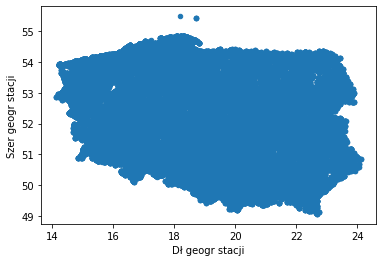

In [22]:
LTE.plot(x='Dł geogr stacji', y='Szer geogr stacji', kind="scatter", colormap="YlOrRd")

In [23]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


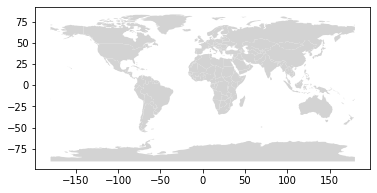

In [24]:
countries.plot(color="lightgrey")

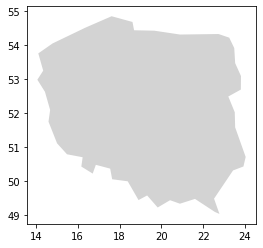

In [25]:
countries[countries["name"] == "Poland"].plot(color="lightgrey")

In [43]:
def create_map_with_RATs(df, title):
    # initialize an axis
    fig, ax = plt.subplots(figsize=(8,6))
    # plot map on axis
    countries = gpd.read_file(  
        gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Poland"].plot(color="lightgrey",
                                                    ax=ax)

    # plot points
    df.plot(x='Dł geogr stacji', y='Szer geogr stacji', kind="scatter", colormap="YlOrRd", 
            title=title, 
            ax=ax)
    # add grid
    ax.grid(b=True, alpha=0.5)
    return plt.show()

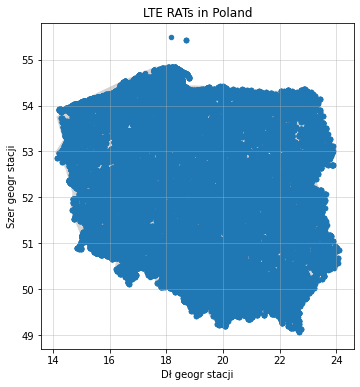

In [44]:
create_map_with_RATs(LTE, 'LTE RATs in Poland')

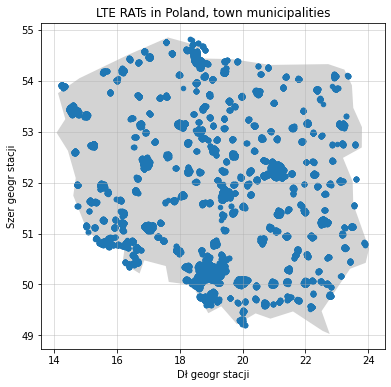

In [46]:
#gminy miejskie
town_municipality_LTE=LTE[LTE['TERYT'].apply(str).str.endswith('1')].reset_index()

create_map_with_RATs(town_municipality_LTE, 'LTE RATs in Poland, town municipalities')

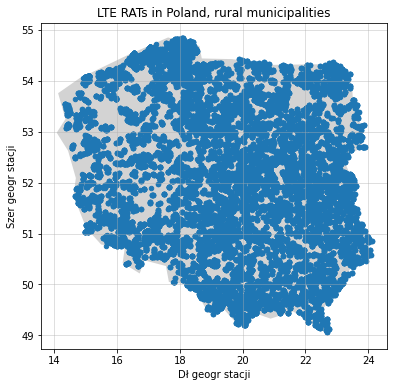

In [47]:
#gminy wiejskie
rural_municipality_LTE=LTE[LTE['TERYT'].apply(str).str.endswith('2')].reset_index()

create_map_with_RATs(rural_municipality_LTE, 'LTE RATs in Poland, rural municipalities')

1. nałożyć na mapę: https://towardsdatascience.com/the-easiest-way-to-plot-data-from-pandas-on-a-world-map-1a62962a27f3
1a. wygenerowac mape dla wroclawia: https://stackoverflow.com/questions/71565032/how-to-see-city-map-when-ploting-with-geopandas-lib
2. Wybrać wg teryt gminy miejskie (1) i wiejskie (2) ostatnia cyfra --> https://pl.wikipedia.org/wiki/TERC i tak zrobić rysunek. zrobić analizy typu jaka firma na jakim terenie
3. analiza na dolny sląsk (26 wg teryt) - jakie firmy, jakie częstotliwości, ile wg miast najwięcej
4. ilość pozwoleń wydanych w poszczególnych latach

###Wroclaw a Legnica

In [27]:
Wroclaw = LTE.loc[LTE['Miejscowość'] == 'Wrocław'].reset_index()
# df.loc[df['column_name'] == some_value]

In [28]:
Wroclaw

,index,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
0,4455,LTE,2600,Orange Polska S.A.,MNET/15/76001/10/18,zmP,2023-04-30,17.118056,51.118056,Wrocław,"Swojczycka 38, 8\66",2352,264011
1,4456,LTE,2600,Orange Polska S.A.,MNET/15/76499/8/18,zmP,2024-05-31,17.042222,51.076111,Wrocław,"Świeradowska 51-57, dz. nr 66\12",14246,264011
2,4457,LTE,2600,Orange Polska S.A.,MNET/15/76560/8/18,zmP,2024-04-30,16.973611,51.165278,Wrocław,dz. nr 38\2,14285,264011
3,4461,LTE,2600,Orange Polska S.A.,MNET/15/77003/10/20,zmP,2023-05-31,16.992500,51.111667,Wrocław,"Fabryczna 10, 1/13",2413,264011
4,4462,LTE,2600,Orange Polska S.A.,MNET/15/77004/11/20,zmP,2023-05-31,17.025556,51.091389,Wrocław,"Komandorska 118/120, 16",2371,264011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,868,LTE,900,T-Mobile Polska S.A.,MNET/11/76174/10/22,zmP,2023-04-30,17.022222,51.139167,Wrocław,"Bezpieczna 28/34, 114/2",46174,264011
2078,869,LTE,900,T-Mobile Polska S.A.,MNET/11/76187/10/22,zmP,2023-06-30,17.042500,51.105556,Wrocław,"Józefa Ignacego Kraszewskiego 27/31, 21/2",46187,264011
2079,870,LTE,900,T-Mobile Polska S.A.,MNET/11/76417/8/22,zmP,2024-07-31,17.060278,51.119167,Wrocław,"Walecznych 15, 20",42568,264011
2080,871,LTE,900,T-Mobile Polska S.A.,MNET/11/76421/11/22,zmP,2023-04-30,17.080000,51.138611,Wrocław,"Bolesława Krzywoustego 107, 100/6",46421,264011


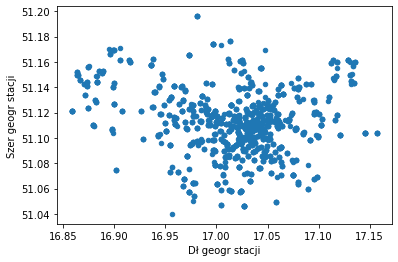

In [30]:
Wroclaw.plot(x='Dł geogr stacji', y='Szer geogr stacji', kind="scatter", colormap="YlOrRd")

In [32]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x = Wroclaw['Dł geogr stacji']
y = Wroclaw['Szer geogr stacji']

points = list(zip(x,y))
distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
avg_distance = sum(distances) / len(distances)

In [34]:
dist = [distance(p1,p2).km for p1, p2 in combinations(points,2)]
avg_dist = sum(dist) / len(dist)

In [35]:
avg_dist

7.796126274640078

In [36]:
Legnica = LTE.loc[LTE['Miejscowość'] == 'Legnica'].reset_index()
Legnica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              217 non-null    int64         
 1   RAT                217 non-null    object        
 2   Częstotliwość      217 non-null    object        
 3   Nazwa Operatora    217 non-null    object        
 4   Nr Decyzji         217 non-null    object        
 5   Rodzaj decyzji     217 non-null    object        
 6   Data ważności      217 non-null    datetime64[ns]
 7   Dł geogr stacji    217 non-null    float64       
 8   Szer geogr stacji  217 non-null    float64       
 9   Miejscowość        217 non-null    object        
 10  Lokalizacja        217 non-null    object        
 11  IdStacji           217 non-null    object        
 12  TERYT              217 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usag

In [37]:
x_Legnica = Legnica['Dł geogr stacji']
y_Legnica = Legnica['Szer geogr stacji']

points_Legnica = list(zip(x_Legnica,y_Legnica))

dist = [distance(p1,p2).km for p1, p2 in combinations(points_Legnica,2)]
avg_dist_Legnica = sum(dist) / len(dist)

In [38]:
avg_distance

0.07108527826870514

In [39]:
avg_dist_Legnica

3.6086782041515075

In [40]:
density_Wroclaw = Wroclaw.shape[0] / 292.8 
density_Legnica =  Legnica.shape[0] / 56.29

In [ ]:
f'zageszczenie w legnicy to  {round(density_Legnica,2)} BTSy na km2 a Wroclaw to {round(density_Wroclaw,2)} na km2' 

'zageszczenie w legnicy to  3.86 BTSy na km2 a Wroclaw to 7.11 na km2'

###Operatorzy

In [48]:
LTE['Nazwa Operatora'].unique()

array(['AERO 2 Sp. z o.o.', 'Orange Polska S.A.', 'P4 Sp. z o.o.',
       'POLKOMTEL Sp. z o.o.', 'T-Mobile Polska S.A.', 'PGE Systemy S.A.'],
      dtype=object)

In [75]:
Operatorzy = pd.DataFrame(LTE.groupby(['Nazwa Operatora'])['Nazwa Operatora'].count().reset_index(name="RATs count")).sort_values(by='RATs count', ascending=False)
Operatorzy
# df2 = df.groupby(['Courses'])['Courses'].count()

,Nazwa Operatora,RATs count
2,P4 Sp. z o.o.,37519
1,Orange Polska S.A.,25637
5,T-Mobile Polska S.A.,25039
0,AERO 2 Sp. z o.o.,6841
4,POLKOMTEL Sp. z o.o.,1299
3,PGE Systemy S.A.,4


In [76]:
Operatorzy_miasta = pd.DataFrame(town_municipality_LTE.groupby(['Nazwa Operatora'])['Nazwa Operatora'].count().reset_index(name="RATs on town area")).sort_values(by='RATs on town area', ascending=False)
Operatorzy_miasta

,Nazwa Operatora,RATs on town area
2,P4 Sp. z o.o.,18752
1,Orange Polska S.A.,12270
5,T-Mobile Polska S.A.,12188
0,AERO 2 Sp. z o.o.,3465
4,POLKOMTEL Sp. z o.o.,557
3,PGE Systemy S.A.,3


In [77]:
Operatorzy_wsie = pd.DataFrame(rural_municipality_LTE.groupby(['Nazwa Operatora'])['Nazwa Operatora'].count().reset_index(name='RATs on rural areas')).sort_values(by='RATs on rural areas', ascending=False)
Operatorzy_wsie

,Nazwa Operatora,RATs on rural areas
2,P4 Sp. z o.o.,10827
1,Orange Polska S.A.,7660
4,T-Mobile Polska S.A.,7453
0,AERO 2 Sp. z o.o.,1857
3,POLKOMTEL Sp. z o.o.,363


In [87]:
Operatorzy_razem=pd.merge(pd.merge(Operatorzy, Operatorzy_miasta, on='Nazwa Operatora'), Operatorzy_wsie, on='Nazwa Operatora', how='left')
Operatorzy_razem['RATs on rural areas'] = Operatorzy_razem['RATs on rural areas'].fillna(0).astype(int)
Operatorzy_razem

,Nazwa Operatora,RATs count,RATs on town area,RATs on rural areas
0,P4 Sp. z o.o.,37519,18752,10827
1,Orange Polska S.A.,25637,12270,7660
2,T-Mobile Polska S.A.,25039,12188,7453
3,AERO 2 Sp. z o.o.,6841,3465,1857
4,POLKOMTEL Sp. z o.o.,1299,557,363
5,PGE Systemy S.A.,4,3,0


###PGE

In [88]:
LTE[LTE['Nazwa Operatora']=='PGE Systemy S.A.']

,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
0,LTE,450,PGE Systemy S.A.,LTE450/18/120001/1/21,P,2031-02-28,23.170000,53.129444,Białystok,Elektryczna 13,120001,2061011
1,LTE,450,PGE Systemy S.A.,LTE450/18/120002/1/21,P,2031-02-28,23.010833,53.853333,Augustów,Elektryczna 2,120002,2001011
2,LTE,450,PGE Systemy S.A.,LTE450/18/330001/1/21,P,2031-02-28,16.896389,52.449722,Poznań,Strzeszyńska 58,330001,3064011
3,LTE,450,PGE Systemy S.A.,LTE450/18/330002/1/21,P,2031-02-28,17.557500,52.335000,Września,Czerniejewska 2a,330002,3030054


###Pozwolenia